# Modelo detección de fraude biométrico en proceso de onboarding digital

## Desarrollo modelo CLASE III A: Verificar que la imagen no haya sido adulterada con un rostro recortado y sobrepuesto

### Descripción:
Este caso es más complejo, ya que no se pude determinar por diferencias de color

#### Dependencias

In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import dlib

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from joblib import dump, load


import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout



import dlib
from PIL import Image, ImageDraw
import numpy as np

import os
import pandas as pd
from PIL import Image
import dlib


import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np


from tensorflow.keras import backend as K
from sklearn.metrics import f1_score
import numpy as np
from tensorflow.keras.callbacks import Callback

In [2]:
# Rutas a los modelos y datos
model_paths = {
    'predictor_path': "../../modelos/shape_predictor_68_face_landmarks.dat",
    'face_rec_model_path': "../../modelos/dlib_face_recognition_resnet_model_v1.dat",
}


In [3]:
def linearize_oval_face_contour(image_pil, n, output_size=(50, 50)):
    # Convierte la imagen PIL a un array de NumPy para su procesamiento
    image_np = np.array(image_pil)
    
    # Cargar modelos de dlib (asumiendo que ya están definidos anteriormente)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(model_paths['predictor_path'])
    
    # Detectar rostros en la imagen
    detected_faces = detector(image_np, 1)
    
    if not detected_faces:
        raise ValueError("No faces detected in the image.")
    
    # Selecciona el primer rostro detectado (se puede modificar para manejar múltiples rostros)
    face = detected_faces[0]
    
    # Obtener los landmarks del rostro
    landmarks = predictor(image_np, face)
    
    # Extraer los puntos del contorno del rostro (parte del óvalo, excluyendo los ojos)
    # Los puntos 1 a 17 delinean el contorno del rostro en el modelo de 68 puntos
    contour_points = np.array([[landmarks.part(i).x, landmarks.part(i).y] for i in range(0, 17)])
    
    # Ancho total del resultado basado en el ancho del óvalo más extensiones
    width = 2 * n + 1  # n a cada lado más el punto central
    height = len(contour_points)
    
    # Crear una nueva imagen PIL para el resultado
    result_image = Image.new('RGB', (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(result_image)
    
    # Pintar cada línea del óvalo extendido en la nueva imagen
    for i, (x, y) in enumerate(contour_points):
        left_x = n
        for offset in range(-n, n + 1):
            source_x = x + offset
            if 0 <= source_x < image_np.shape[1]:
                color = tuple(image_np[y, source_x])  # Captura el color del pixel original
                draw.point((left_x + offset, i), fill=color)
    
    # Redimensionar la imagen resultante a 50x50 píxeles
    result_image = result_image.resize(output_size, Image.Resampling.LANCZOS)
  
   
    
    return result_image

# Uso de la función
# image_pil = Image.open('path_to_your_image.jpg')
# result_image = linearize_oval_face_contour(image_pil, n=10)
# result_image.show()


In [4]:


# Asumiendo que la función linearize_oval_face_contour ya ha sido definida como la discutida anteriormente.

def load_and_process_images(directory, label, n=10, output_size=(50, 50)):
    # Lista para almacenar los datos
    data = {'Image': [], 'Label': []}
    
    # Cargar modelos de dlib (asegúrate de que las rutas a los modelos están correctamente configuradas)

    # Obtener lista de archivos PNG en el directorio
    files = [f for f in os.listdir(directory) if f.endswith('.png')]
    
    # Iterar sobre cada archivo en el directorio con tqdm para visualizar el progreso
    for filename in tqdm(files, desc="Processing images"):
        # Construir la ruta completa al archivo
        file_path = os.path.join(directory, filename)
        
        # Cargar la imagen
        image = Image.open(file_path)
        
        # Procesar la imagen
        try:
            processed_image = linearize_oval_face_contour(image, n, output_size)
            # Guardar la imagen y la etiqueta en el diccionario
            data['Image'].append(processed_image)
            data['Label'].append(label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Crear DataFrame desde el diccionario
    df = pd.DataFrame(data)
    
    return df

# Ejemplo de uso:
# directory_path = 'path_to_your_directory'
# label = 'your_label'
# df_images = load_and_process_images(directory_path, label)
# print(df_images)


In [5]:

# Cargar modelos de dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model_paths['predictor_path'])
face_rec_model = dlib.face_recognition_model_v1(model_paths['face_rec_model_path'])

In [6]:
demo_real = "../../data/train/CLASE III, FAKE_BW/ID_REAL/ID/ID_REAL_0.png"
demo_FAKE_III = "../../data/train/CLASE III, FAKE_BW/ID_FAKE_III/ID_A/ID_FAKE_III_A_144.png"


### Ejemplo y exploración

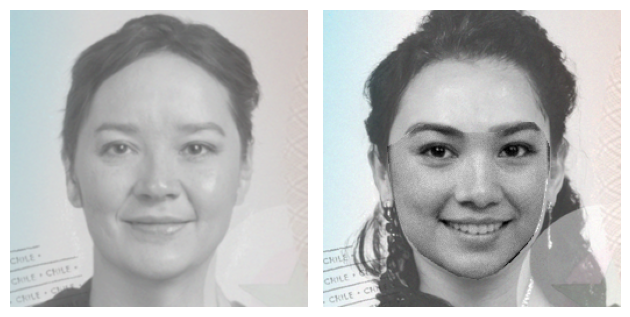

In [7]:
real = Image.open(demo_real)
fake_III = Image.open(demo_FAKE_III)

fig, axes = plt.subplots(1, 2) 

axes[0].imshow(real)
axes[0].axis('off')  

axes[1].imshow(fake_III)
axes[1].axis('off')



plt.tight_layout()
plt.show()

In [8]:
path_destino_ID_REAL = "../../data/train/CLASE III, FAKE_BW//ID_REAL/ID"
path_destino_VAL_REAL = "../../data/train/CLASE III, FAKE_BW//ID_REAL/VAL"

path_destino_ID_FAKE_III_A = "../../data/train/CLASE III, FAKE_BW//ID_FAKE_III/ID_A"
path_destino_VAL_FAKE_III_A = "../../data/train/CLASE III, FAKE_BW//ID_FAKE_III/VAL_A"




Mediante la observación de las muestras, se observó que la mejor manera de detectar este tipo de fraude, es focalizar el análisis a los puntos de unión entre el rostro recortado y el rostro destino.    
Se realizó una exploración de la zona:

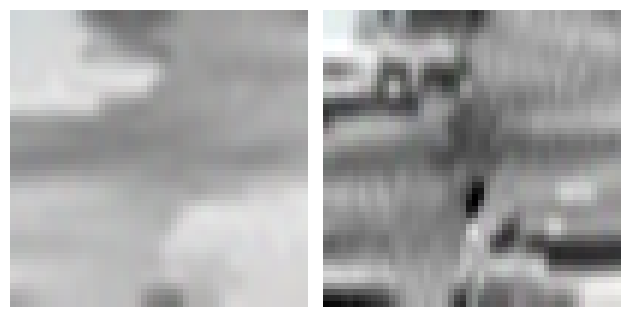

In [9]:
result_image_real = linearize_oval_face_contour(real, n=20)
result_image_fake_III = linearize_oval_face_contour(fake_III, n=20)

fig, axes = plt.subplots(1, 2) 

axes[0].imshow(result_image_real)
axes[0].axis('off')  

axes[1].imshow(result_image_fake_III )
axes[1].axis('off')



plt.tight_layout()
plt.show()

De la observación, se nota como la focalización en la zona específica permite resaltar pixels de unión entre los tonos originales y los de la imágen externa

In [10]:
result_image_fake_III.size

(50, 50)

In [11]:
#df_real = pd.read_pickle('df_real.pkl')
#df_fake_III_A = pd.read_pickle('df_fake_III_A.pkl')

In [12]:
df_real = load_and_process_images(path_destino_ID_REAL, 0)
df_real

Processing images:  36%|███▋      | 1822/5000 [19:44<34:15,  1.55it/s]

Error processing ../../data/train/CLASE III, FAKE_BW//ID_REAL/ID\ID_REAL_2637.png: No faces detected in the image.


Processing images:  37%|███▋      | 1871/5000 [20:16<33:48,  1.54it/s]

Error processing ../../data/train/CLASE III, FAKE_BW//ID_REAL/ID\ID_REAL_2681.png: No faces detected in the image.


Processing images: 100%|██████████| 5000/5000 [56:32<00:00,  1.47it/s]


,Image,Label
0,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
1,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
2,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
3,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
4,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
...,...,...
4993,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
4994,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
4995,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
4996,<PIL.Image.Image image mode=RGB size=50x50 at ...,0


In [13]:
#df_real.to_pickle('df_real.pkl')

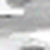

In [14]:
df_real['Image'][2]

In [15]:
df_fake_III_A = load_and_process_images(path_destino_ID_FAKE_III_A , 1)
df_fake_III_A 

Processing images: 100%|██████████| 5000/5000 [1:05:31<00:00,  1.27it/s]


,Image,Label
0,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
1,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
2,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
3,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
4,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
...,...,...
4995,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
4996,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
4997,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
4998,<PIL.Image.Image image mode=RGB size=50x50 at ...,1


In [16]:
#df_fake_III_A.to_pickle('df_fake_III_A.pkl')

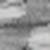

In [17]:
df_fake_III_A['Image'][5]

In [18]:

# Concatenar los DataFrames en un solo DataFrame base
df_base = pd.concat([df_real, df_fake_III_A], ignore_index=True)
df_base

,Image,Label
0,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
1,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
2,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
3,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
4,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
...,...,...
9993,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
9994,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
9995,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
9996,<PIL.Image.Image image mode=RGB size=50x50 at ...,1


In [19]:
# Convertir imágenes de PIL Image a arrays de NumPy
df_base['Image'] = df_base['Image'].apply(lambda x: img_to_array(x))


In [20]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = np.stack(df_base['Image'])  # Crear un array de numpy para las imágenes
y = df_base['Label'].values  # Etiquetas


In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)


In [22]:

# Normalizar los datos
X_train = X_train / 255.0
X_test = X_test / 255.0


PARA DETERMINAR EPOCH

In [23]:

# Definir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(50, 50, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:

history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.4)



Epoch 1/40
66/66 [==============================] - 9s 128ms/step - loss: 0.5379 - accuracy: 0.7141 - val_loss: 0.3896 - val_accuracy: 0.8104
Epoch 2/40
66/66 [==============================] - 8s 127ms/step - loss: 0.2633 - accuracy: 0.8961 - val_loss: 0.1885 - val_accuracy: 0.9300
Epoch 3/40
66/66 [==============================] - 8s 126ms/step - loss: 0.1802 - accuracy: 0.9369 - val_loss: 0.1383 - val_accuracy: 0.9457
Epoch 4/40
66/66 [==============================] - 8s 127ms/step - loss: 0.1497 - accuracy: 0.9431 - val_loss: 0.1026 - val_accuracy: 0.9639
Epoch 5/40
66/66 [==============================] - 8s 128ms/step - loss: 0.1203 - accuracy: 0.9562 - val_loss: 0.0988 - val_accuracy: 0.9614
Epoch 6/40
66/66 [==============================] - 8s 128ms/step - loss: 0.0997 - accuracy: 0.9647 - val_loss: 0.1093 - val_accuracy: 0.9607
Epoch 7/40
66/66 [==============================] - 8s 128ms/step - loss: 0.1079 - accuracy: 0.9581 - val_loss: 0.1061 - val_accuracy: 0.9636
Epoch 

In [25]:

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


94/94 [==============================] - 2s 16ms/step - loss: 0.0435 - accuracy: 0.9857
Test Accuracy: 98.57%


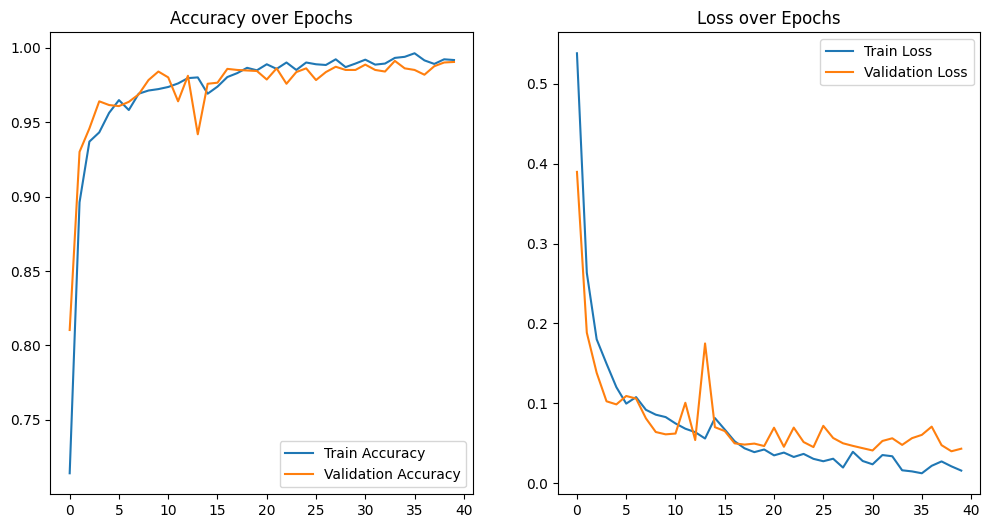

In [26]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()

plot_history(history)


FINAL

In [27]:

# Definir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(50, 50, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [28]:

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.4)



Epoch 1/20
66/66 [==============================] - 9s 131ms/step - loss: 0.5378 - accuracy: 0.7001 - val_loss: 0.2818 - val_accuracy: 0.8864
Epoch 2/20
66/66 [==============================] - 8s 128ms/step - loss: 0.2929 - accuracy: 0.8833 - val_loss: 0.2167 - val_accuracy: 0.9157
Epoch 3/20
66/66 [==============================] - 8s 128ms/step - loss: 0.2169 - accuracy: 0.9121 - val_loss: 0.1475 - val_accuracy: 0.9429
Epoch 4/20
66/66 [==============================] - 8s 129ms/step - loss: 0.1746 - accuracy: 0.9314 - val_loss: 0.1177 - val_accuracy: 0.9529
Epoch 5/20
66/66 [==============================] - 8s 128ms/step - loss: 0.1528 - accuracy: 0.9443 - val_loss: 0.1230 - val_accuracy: 0.9486
Epoch 6/20
66/66 [==============================] - 8s 128ms/step - loss: 0.1372 - accuracy: 0.9497 - val_loss: 0.1231 - val_accuracy: 0.9471
Epoch 7/20
66/66 [==============================] - 9s 131ms/step - loss: 0.1155 - accuracy: 0.9557 - val_loss: 0.0957 - val_accuracy: 0.9646
Epoch 

In [29]:

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


94/94 [==============================] - 2s 17ms/step - loss: 0.0876 - accuracy: 0.9563
Test Accuracy: 95.63%


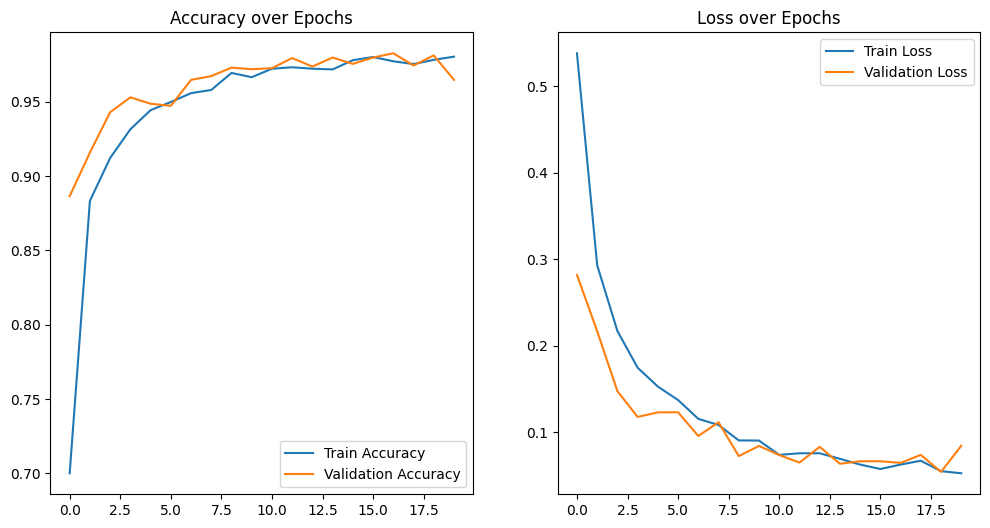

In [30]:

def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()

plot_history(history)


94/94 [==============================] - 2s 17ms/step


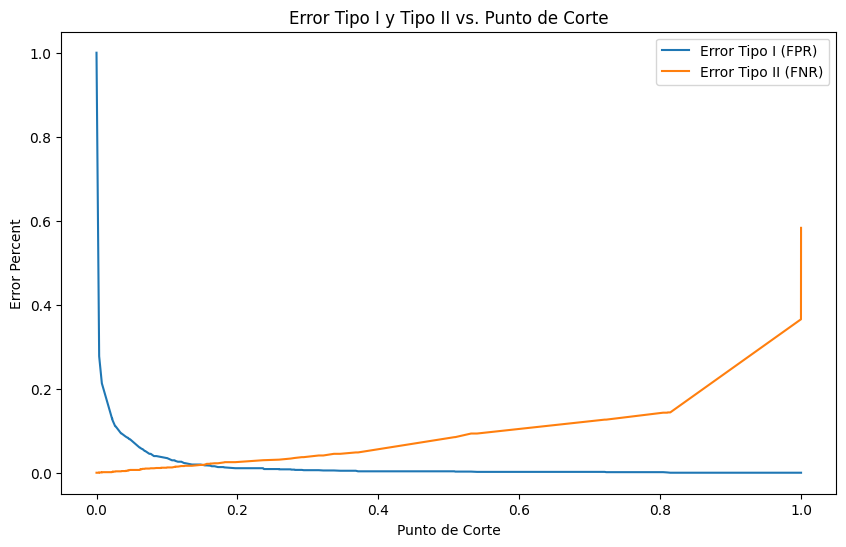

In [31]:
from sklearn.metrics import roc_curve

# Obtener probabilidades
y_probs = model.predict(X_test)[:, 0]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calcular Error Tipo I y II para cada umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fpr, label='Error Tipo I (FPR)')
plt.plot(thresholds, 1 - tpr, label='Error Tipo II (FNR)')
plt.title('Error Tipo I y Tipo II vs. Punto de Corte')
plt.xlabel('Punto de Corte')
plt.ylabel('Error Percent')
plt.legend()
plt.show()


94/94 [==============================] - 2s 17ms/step


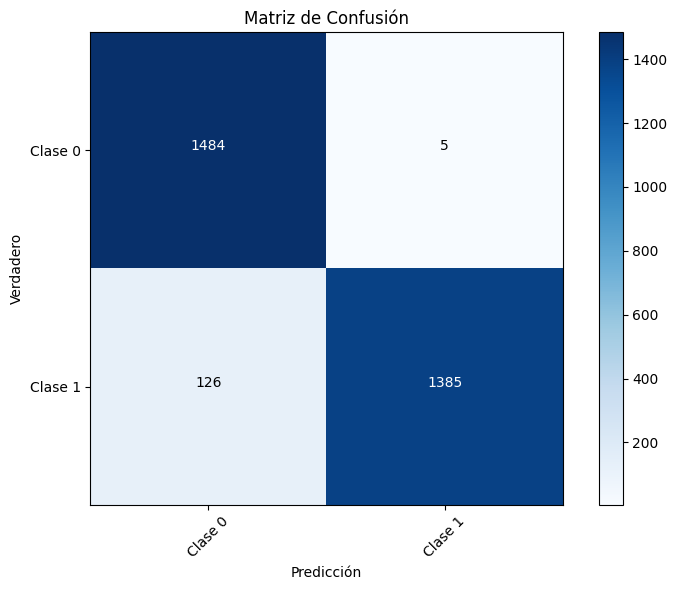

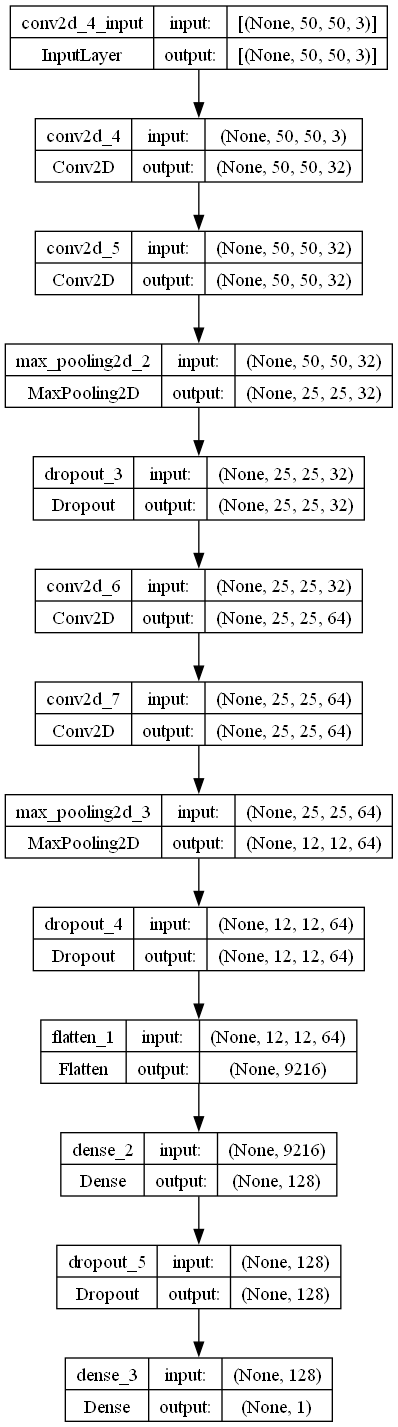

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import itertools  # Importar itertools

# Asumiendo que `model` es tu modelo entrenado y `X_test`, `y_test` son tus datos de prueba
# Obtener predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).astype(int)  # Redondear y convertir a int si tus etiquetas son binarias

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
tick_marks = np.arange(2)  # Ajustar según el número de clases
plt.xticks(tick_marks, ['Clase 0', 'Clase 1'], rotation=45)
plt.yticks(tick_marks, ['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')

# Añadir anotaciones de texto en las celdas
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Graficar la configuración del modelo
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [33]:
#path_modelos_finales="./"


In [34]:
#model.save(path_modelos_finales+"/CLASE_III_A_CNN.h5")
